In [1]:
from datetime import datetime
import json
from collections import Counter

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torchmetrics

from deeprec.torch.trainer import Trainer, set_device
from deeprec import ROOT

In [2]:
with open('../data/metadata.json', 'r') as fp:
    meta = json.load(fp)

meta.keys()

dict_keys(['title_emb_size', 'string_na', 'genres', 'ages', 'occupations', 'user', 'movie', 'city', 'state'])

In [3]:
class Vocab(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x):
        c = Counter(x)
        self.lookup_ = {
            str(v).lower(): k for k, v in enumerate([x[0] for x in sorted(c.items(), key=lambda x: x[1], reverse=True)])
        }

    def transform(self, x):
        return [self.lookup_.get(str(xx).lower(), len(self.lookup_)+1) for xx in x]

In [204]:
df = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
df.head()

,user,movie,hour,day_of_week,month,ts,gender,age,occupation,city,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
693094,1489,2648,3,5,11,2000-11-25 03:35:14,1,35,2,Evanston,...,0.059832,0.46583,0.774960,0.43321,0.370830,0.140020,0.521110,-0.960430,-0.622770,0.245130
563664,2440,3101,17,1,11,2000-11-14 17:03:49,0,50,17,Ashburnham,...,1.982520,0.84989,1.708770,1.34452,-1.051670,-0.032240,0.662540,-0.448420,-1.197040,-0.698660
192,682,1193,16,3,11,2000-11-30 16:33:10,0,25,4,Carrboro,...,2.176160,2.86298,2.238394,-2.15952,1.210480,-3.436165,-0.329595,3.619880,-2.470530,1.399963
664671,3512,1005,17,0,8,2000-08-28 17:16:19,0,18,17,Cambridge,...,-1.662040,0.99335,-1.184181,1.58626,0.718946,-1.731300,2.357530,1.096584,-2.896070,0.150750
967203,5074,1202,5,5,7,2000-07-01 05:14:36,0,1,0,Purcellville,...,1.998510,1.07155,-0.863230,0.24211,-0.773756,0.235041,1.170840,-2.078201,-1.310696,-0.964250


In [5]:
state_enc = Vocab()
state_enc.fit(df['state'])

user_enc = Vocab()
user_enc.fit(df['user'])

movie_enc = Vocab()
movie_enc.fit(df['movie'])

In [6]:
df = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])
df.head()

,rating
index,
693094,3
563664,4
192,5
664671,3
967203,5


In [7]:
set(df['rating'])

{1, 2, 3, 4, 5}

In [86]:
class MovieDataset(Dataset):
    def __init__(self, filename, vocabs):
        data = pd.read_parquet(filename, columns=['user', 'movie', 'rating'])
        data['user'] = vocabs['user'].transform(data['user'])
        data['movie'] = vocabs['movie'].transform(data['movie'])

        self.feature_names = data.columns[:-1]
        self.data = data.to_dict('records')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [192]:
def collator(batch):
    inputs = {}
    elems = [k for k in batch[0].keys() if k != 'rating']
    for e in elems:
        inputs[e] = torch.tensor([x[e] for x in batch])#.unsqueeze(-1)
    labels = torch.tensor([x['rating'] for x in batch], dtype=torch.float32)#.unsqueeze(-1)
    return inputs, labels

In [91]:
encoders = {
    'user': user_enc,
    'movie': movie_enc,
    'state': state_enc
}

train = MovieDataset('../data/train.parq.gzip', vocabs=encoders)
test = MovieDataset('../data/test.parq.gzip', vocabs=encoders)

In [193]:
dl = DataLoader(train, 4, collate_fn=collator)
next(iter(dl))


({'user': tensor([ 406, 5675, 3393,  579]),
  'movie': tensor([ 779,  309,   42, 1741])},
 tensor([3., 4., 5., 3.]))

In [194]:
class RecModel(nn.Module):
    def __init__(self, metadata, n_features=54):
        super().__init__()
        self.meta = metadata
        self.embed_dims = {
            'large': 32,
            'med': 16,
            'small': 8,
        }
        self.loss_func = nn.MSELoss()

        self.user_embeds = nn.Embedding(
            num_embeddings=len(user_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.movie_embeds = nn.Embedding(
            num_embeddings=len(movie_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['large']
        )

        self.model = nn.Sequential(
            nn.Linear(in_features=64, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        user_block = self.user_embeds(x['user'])
        movie_block = self.movie_embeds(x['movie'])
        # print(user_block.shape)
        # print(movie_block.shape)
        # print(torch.concat((user_block, movie_block), dim=-1).shape)
        x = self.model(torch.concat((user_block, movie_block), dim=-1))
        return x.squeeze(-1)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return self(x)

In [195]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
MODEL_NAME = 'simple-collab-filter'
LOG_DIR = ROOT.joinpath('runs', MODEL_NAME, NOW)
BATCH = 2500
EPOCHS = 15

train_loader = DataLoader(train, batch_size=BATCH, shuffle=True, collate_fn=collator)
test_loader = DataLoader(test, batch_size=BATCH, collate_fn=collator)

device = set_device()
mod = RecModel(metadata=meta)
opt = torch.optim.AdamW(mod.parameters(), lr=1e-2)
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=.5)

trainer = Trainer(
    mod, epochs=EPOCHS, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': torchmetrics.MeanSquaredError()}, lr_schedule=sch
)
trainer.fit(train_loader, test_loader, verbose=True)

Batch:  99%|█████████▊| 356/361 [00:04<00:00, 50.89it/s]
                                                        
Epoch:   7%|▋         | 1/15 [00:04<01:06,  4.75s/it]  

defaultdict(<class 'list'>, {'epoch': [0], 'train_loss': [1.201069306798919], 'train_mse': [1.1449646949768066], 'valid_loss': [0.8794754714500613], 'valid_mse': [0.865179181098938]})



Batch:  99%|█████████▉| 357/361 [00:04<00:00, 79.79it/s]
                                                        
Epoch:  13%|█▎        | 2/15 [00:09<00:59,  4.60s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1], 'train_loss': [1.201069306798919, 0.8411755606408264], 'train_mse': [1.1449646949768066, 0.8260855078697205], 'valid_loss': [0.8794754714500613, 0.8621613368755434], 'valid_mse': [0.865179181098938, 0.8521650433540344]})



Batch:  99%|█████████▊| 356/361 [00:04<00:00, 83.66it/s]
                                                        
Epoch:  20%|██        | 3/15 [00:14<00:58,  4.90s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658]})



Batch:  99%|█████████▉| 357/361 [00:03<00:00, 107.58it/s]
                                                         
Epoch:  27%|██▋       | 4/15 [00:18<00:49,  4.47s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799]})



Batch: 100%|█████████▉| 360/361 [00:04<00:00, 93.39it/s] 
                                                        
Epoch:  33%|███▎      | 5/15 [00:23<00:47,  4.74s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8470094799995422]})



Batch:  99%|█████████▊| 356/361 [00:04<00:00, 70.12it/s]
                                                        
Epoch:  40%|████      | 6/15 [00:28<00:43,  4.80s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8470094799995422, 0.8272314667701721]})



Batch:  98%|█████████▊| 355/361 [00:04<00:00, 83.32it/s]
                                                        
Epoch:  47%|████▋     | 7/15 [00:33<00:38,  4.79s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8470094799995422, 0.8272314667701721, 0.8259232044219971]})



Batch: 100%|██████████| 361/361 [00:05<00:00, 88.69it/s] 
                                                        
Epoch:  53%|█████▎    | 8/15 [00:38<00:35,  5.03s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027, 0.7468218697735477], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083, 0.7378636002540588], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906, 0.8380538515928315], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8470094799995422, 0.8272314667701721, 0.8259232044219971, 0.8261405229568481]})



Batch:  97%|█████████▋| 351/361 [00:03<00:00, 103.92it/s]
                                                         
Epoch:  60%|██████    | 9/15 [00:43<00:28,  4.83s/it]  

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027, 0.7468218697735477, 0.7388016695461115], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083, 0.7378636002540588, 0.7294624447822571], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906, 0.8380538515928315, 0.8353465824592404], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8470094799995422, 0.8272314667701721, 0.8259232044219971, 0.8261405229568481, 0.8269175887107849]})



Batch: 100%|██████████| 361/361 [00:04<00:00, 109.31it/s]
                                                         
Epoch:  67%|██████▋   | 10/15 [00:48<00:24,  4.93s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027, 0.7468218697735477, 0.7388016695461115, 0.730440544454675], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083, 0.7378636002540588, 0.7294624447822571, 0.7206934690475464], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906, 0.8380538515928315, 0.8353465824592404, 0.8350527635434779], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8470094799995422, 0.8272314667701721, 0.8259232044219971, 0.8261405229568481, 0.8269175887107849, 0.824329137802124]})



Batch:  99%|█████████▉| 358/361 [00:04<00:00, 74.04it/s]
                                                        
Epoch:  73%|███████▎  | 11/15 [00:52<00:19,  4.84s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027, 0.7468218697735477, 0.7388016695461115, 0.730440544454675, 0.70787652162964], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083, 0.7378636002540588, 0.7294624447822571, 0.7206934690475464, 0.7029990553855896], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906, 0.8380538515928315, 0.8353465824592404, 0.8350527635434779, 0.8317062316871271], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8470094799995422, 0.8272314667701721, 0.8259232044219971, 0.8261405229568481, 0.8269175887107849, 0.824329137802124, 0.8208140134


Batch:  98%|█████████▊| 353/361 [00:04<00:00, 106.18it/s]
                                                         
Epoch:  80%|████████  | 12/15 [00:58<00:14,  4.97s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027, 0.7468218697735477, 0.7388016695461115, 0.730440544454675, 0.70787652162964, 0.7011598852202503], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083, 0.7378636002540588, 0.7294624447822571, 0.7206934690475464, 0.7029990553855896, 0.6957352757453918], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906, 0.8380538515928315, 0.8353465824592404, 0.8350527635434779, 0.8317062316871271, 0.8302480622035701], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8470094799995422, 0.8272314667701721, 0.8259232044219971, 0.82614


Batch: 100%|██████████| 361/361 [00:04<00:00, 96.84it/s] 
                                                        
Epoch:  87%|████████▋ | 13/15 [01:03<00:09,  4.98s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027, 0.7468218697735477, 0.7388016695461115, 0.730440544454675, 0.70787652162964, 0.7011598852202503, 0.6952024001494008], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083, 0.7378636002540588, 0.7294624447822571, 0.7206934690475464, 0.7029990553855896, 0.6957352757453918, 0.6899204254150391], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906, 0.8380538515928315, 0.8353465824592404, 0.8350527635434779, 0.8317062316871271, 0.8302480622035701, 0.8302524744010553], 'valid_mse': [0.865179181098938, 0.8521650433540344, 0.8522827625274658, 0.8452692627906799, 0.8


Batch: 100%|██████████| 361/361 [00:04<00:00, 57.64it/s]
                                                        
Epoch:  93%|█████████▎| 14/15 [01:08<00:05,  5.05s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027, 0.7468218697735477, 0.7388016695461115, 0.730440544454675, 0.70787652162964, 0.7011598852202503, 0.6952024001494008, 0.6894688764767634], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083, 0.7378636002540588, 0.7294624447822571, 0.7206934690475464, 0.7029990553855896, 0.6957352757453918, 0.6899204254150391, 0.68399977684021], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906, 0.8380538515928315, 0.8353465824592404, 0.8350527635434779, 0.8317062316871271, 0.8302480622035701, 0.8302524744010553, 0.8306073095740342], 'valid_mse': [0.865179181098938, 0


Batch:  99%|█████████▉| 358/361 [00:04<00:00, 121.21it/s]
                                                         
Epoch: 100%|██████████| 15/15 [01:12<00:00,  4.86s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'train_loss': [1.201069306798919, 0.8411755606408264, 0.8207952824325773, 0.8053944356883992, 0.7932356427581027, 0.7627526378037196, 0.7541403085241027, 0.7468218697735477, 0.7388016695461115, 0.730440544454675, 0.70787652162964, 0.7011598852202503, 0.6952024001494008, 0.6894688764767634, 0.6836097469950647], 'train_mse': [1.1449646949768066, 0.8260855078697205, 0.8064652681350708, 0.790850818157196, 0.7781486511230469, 0.7550997138023376, 0.7455329298973083, 0.7378636002540588, 0.7294624447822571, 0.7206934690475464, 0.7029990553855896, 0.6957352757453918, 0.6899204254150391, 0.68399977684021, 0.6778567433357239], 'valid_loss': [0.8794754714500613, 0.8621613368755434, 0.8628146299501744, 0.8539448656686922, 0.8576397154389358, 0.8398315543081702, 0.8386517036251906, 0.8380538515928315, 0.8353465824592404, 0.8350527635434779, 0.8317062316871271, 0.8302480622035701, 0.8302524744010553, 0.830607309

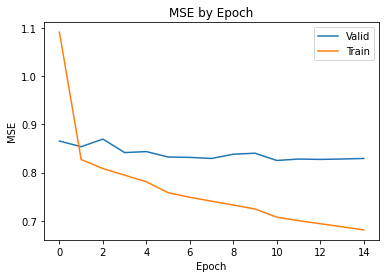

In [154]:
import matplotlib.pyplot as plt

plt.plot(trainer.results['valid_mse'], label='Valid')
plt.plot(trainer.results['train_mse'], label='Train')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE by Epoch')
plt.show()

In [155]:
{e:v for e,v in enumerate(torch.sqrt(torch.tensor(trainer.results['valid_mse'])))}

{0: tensor(0.9303),
 1: tensor(0.9240),
 2: tensor(0.9324),
 3: tensor(0.9173),
 4: tensor(0.9185),
 5: tensor(0.9123),
 6: tensor(0.9119),
 7: tensor(0.9107),
 8: tensor(0.9155),
 9: tensor(0.9166),
 10: tensor(0.9084),
 11: tensor(0.9100),
 12: tensor(0.9096),
 13: tensor(0.9100),
 14: tensor(0.9107)}

<hr>

# DEBUGGING

In [260]:
x = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
y = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])

In [265]:
user = 1489
movies = [int(x) for x in list(meta['movie'].keys())[0:10]]

encoded_user = torch.tensor(user_enc.transform([user]))
# movies = torch.tensor(movie_enc.transform([2858]))
encoded_movies = torch.tensor(movie_enc.transform(movies))

preds = []
for movie in encoded_movies:
    preds.append(mod.predict({'user': encoded_user, 'movie': torch.tensor([movie])}).item())

preds

[3.663471221923828,
 3.6577887535095215,
 3.576707363128662,
 3.2749342918395996,
 2.3884716033935547,
 3.4115192890167236,
 3.086843490600586,
 3.295685052871704,
 2.7017476558685303,
 3.8420557975769043]

In [266]:
results = pd.DataFrame({'movie': movies, 'pred_rating': preds})
results

,movie,pred_rating
0,2858,3.663471
1,260,3.657789
2,1196,3.576707
3,1210,3.274934
4,480,2.388472
5,2028,3.411519
6,589,3.086843
7,2571,3.295685
8,1270,2.701748
9,593,3.842056


In [267]:
user_mask = (x['user'] == user) & x['movie'].isin(movies)
df_user = x.loc[user_mask]

df_user

,user,movie,hour,day_of_week,month,ts,gender,age,occupation,city,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
102718,1489,589,20,0,11,2000-11-20 20:45:56,1,35,2,Evanston,...,0.396910,0.143238,1.457050,0.89631,0.555875,-1.050984,0.439608,-0.394870,0.262000,-0.055144
141055,1489,2571,20,0,11,2000-11-20 20:24:25,1,35,2,Evanston,...,-0.119660,0.814860,0.704639,0.56349,0.777620,-1.204130,-0.247860,0.100980,-1.281000,-0.359768
47479,1489,260,20,0,11,2000-11-20 20:21:52,1,35,2,Evanston,...,0.759896,1.180367,1.088754,-2.49483,1.888920,-3.611867,-0.968673,-0.477968,-2.449346,0.925348
117260,1489,480,20,0,11,2000-11-20 20:25:13,1,35,2,Evanston,...,-0.187000,0.335541,0.460427,-0.20839,0.745540,-0.621420,0.607130,-0.357409,-2.273740,1.774750
71443,1489,1210,20,0,11,2000-11-20 20:46:17,1,35,2,Evanston,...,1.930435,1.984775,3.203664,-2.36986,0.856150,-5.089112,2.447014,-1.729150,-3.658910,2.566328
23863,1489,1270,20,0,11,2000-11-20 20:45:56,1,35,2,Evanston,...,-1.043880,0.006530,-2.255220,-0.88403,-1.421790,-1.366555,-0.770560,1.041650,-0.876050,-1.741870
129084,1489,1196,19,0,11,2000-11-20 19:59:46,1,35,2,Evanston,...,-0.160883,-1.184947,0.796664,-2.08923,2.708920,-5.271990,-0.341982,2.108941,-5.036370,1.916858
107909,1489,2858,22,0,11,2000-11-20 22:20:36,1,35,2,Evanston,...,-0.250560,0.730900,0.378270,0.77064,1.262100,-1.366550,0.106610,-1.792140,-1.323940,0.102870


In [268]:
y.loc[user_mask]

,rating
index,
102718,4
141055,3
47479,3
117260,2
71443,3
23863,2
129084,3
107909,3


In [269]:
actual_ratings = dict(zip(df_user['movie'], y.loc[user_mask]['rating']))
actual_ratings

{589: 4, 2571: 3, 260: 3, 480: 2, 1210: 3, 1270: 2, 1196: 3, 2858: 3}

In [270]:
results['actual_rating'] = results['movie'].map(actual_ratings)
results

,movie,pred_rating,actual_rating
0,2858,3.663471,3.0
1,260,3.657789,3.0
2,1196,3.576707,3.0
3,1210,3.274934,3.0
4,480,2.388472,2.0
5,2028,3.411519,NaN
6,589,3.086843,4.0
7,2571,3.295685,3.0
8,1270,2.701748,2.0
9,593,3.842056,NaN
